In [11]:
from kan import *
import torch
import torch.nn as nn
import numpy as np
import random
from tqdm import tqdm

In [12]:
def B_batch(x, grid, k=0, device='cpu'):
    """
    # Computes B-spline basis functions B_i(x) of degree k for a batch of x values using cox-deboor algorithm.
    # This corresponds to computing the B_i(x) terms in the formula:
    # spline(x) = c_1 B_1(x) + c_2 B_2(x) + ... + c_n B_n(x)
    """

    x = x.unsqueeze(dim=2)
    grid = grid.unsqueeze(dim=0)

    if k == 0:
        value = (x >= grid[:, :, :-1]) * (x < grid[:, :, 1:])
    else:
        B_km1 = B_batch(x[:, :, 0], grid=grid[0], k=k - 1)

        value = (x - grid[:, :, :-(k + 1)]) / (grid[:, :, k:-1] - grid[:, :, :-(k + 1)]) * B_km1[:, :, :-1] + (
                grid[:, :, k + 1:] - x) / (grid[:, :, k + 1:] - grid[:, :, 1:(-k)]) * B_km1[:, :, 1:]

    value = torch.nan_to_num(value)
    return value

In [13]:
def coef2curve(x_eval, grid, coef, k):
    # Computes the spline(x) = c_1 B_1(x) + c_2 B_2(x) + ... + c_n B_n(x)
    # by taking the weighted sum of B-spline basis functions with coefficients c_i

    b_splines = B_batch(x_eval, grid, k=k)  # Compute all B_i(x) basis values
    y_eval = torch.einsum('ijk,jlk->ijl', b_splines, coef.to(b_splines.device))  # Compute sum of c_i * B_i(x)

    return y_eval

In [14]:
def curve2coef(x_eval, y_eval, grid, k):
    # Estimate spline coefficients c_i from known values y_eval = sum c_i B_i(x_eval)
    # Solves a least-squares problem to find the best-fitting coefficients for the B-spline basis

    batch = x_eval.shape[0]  # Number of samples

    in_dim = x_eval.shape[1]  # Input dimensions (i.e., number of features)

    out_dim = y_eval.shape[2]  # Output dimensions

    n_coef = grid.shape[1] - k - 1  # Number of B-spline basis functions (n), derived from knot count and spline degree

    # Compute B-spline basis matrix: shape (batch, in_dim, n_coef)
    mat = B_batch(x_eval, grid, k)

    # Rearrange basis matrix to match least-squares input dimensions:
    # (in_dim, out_dim, batch, n_coef)
    mat = mat.permute(1, 0, 2)[:, None, :, :].expand(in_dim, out_dim, batch, n_coef)

    # Rearrange target outputs to shape (in_dim, out_dim, batch, 1)
    y_eval = y_eval.permute(1, 2, 0).unsqueeze(dim=3)

    try:
        # Solve least-squares: find coef such that mat @ coef ≈ y_eval
        # coef shape: (in_dim, out_dim, n_coef)
        coef = torch.linalg.lstsq(mat, y_eval).solution[:, :, :, 0]
    except:
        print('lstsq failed')  # Handle rare numerical failures

    return coef  # Return estimated coefficients for spline(x) = sum c_i B_i(x)


In [15]:
def extend_grid(grid, k_extend=0):
    # Extends the knot grid on both sides by repeating the boundary spacing (h)
    # This is necessary for constructing B-splines of degree k, which require additional knots at the boundaries

    h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)

    for i in range(k_extend):
        grid = torch.cat([grid[:, [0]] - h, grid], dim=1)

        grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)

    return grid  # Returns grid extended on both sides by k_extend steps

In [16]:
def sparse_mask(in_dim, out_dim):

    in_coord = torch.arange(in_dim) * 1 / in_dim + 1 / (2 * in_dim)
    out_coord = torch.arange(out_dim) * 1 / out_dim + 1 / (2 * out_dim)

    dist_mat = torch.abs(out_coord[:, None] - in_coord[None, :])
    in_nearest = torch.argmin(dist_mat, dim=0)
    in_connection = torch.stack([torch.arange(in_dim), in_nearest]).permute(1, 0)
    out_nearest = torch.argmin(dist_mat, dim=1)
    out_connection = torch.stack([out_nearest, torch.arange(out_dim)]).permute(1, 0)
    all_connection = torch.cat([in_connection, out_connection], dim=0)
    mask = torch.zeros(in_dim, out_dim)
    mask[all_connection[:, 0], all_connection[:, 1]] = 1.

    return mask

In [17]:
class KANLayer(nn.Module):

    def __init__(self, in_dim=3, out_dim=2, num=5, k=3, noise_scale=0.5, scale_base_mu=0.0, scale_base_sigma=1.0,
                 scale_sp=1.0, base_fun=torch.nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True,
                 sb_trainable=True, device='cpu', sparse_init=False):

        super(KANLayer, self).__init__()
        # size
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.num = num
        self.k = k

        grid = torch.linspace(grid_range[0], grid_range[1], steps=num + 1)[None, :].expand(self.in_dim, num + 1)
        grid = extend_grid(grid, k_extend=k)
        self.grid = torch.nn.Parameter(grid).requires_grad_(False)
        noises = (torch.rand(self.num + 1, self.in_dim, self.out_dim) - 1 / 2) * noise_scale / num

        self.coef = torch.nn.Parameter(curve2coef(self.grid[:, k:-k].permute(1, 0), noises, self.grid, k))

        if sparse_init:
            self.mask = torch.nn.Parameter(sparse_mask(in_dim, out_dim)).requires_grad_(False)
        else:
            self.mask = torch.nn.Parameter(torch.ones(in_dim, out_dim)).requires_grad_(False)

        self.scale_base = torch.nn.Parameter(scale_base_mu * 1 / np.sqrt(in_dim) + \
                                             scale_base_sigma * (torch.rand(in_dim, out_dim) * 2 - 1) * 1 / np.sqrt(
            in_dim)).requires_grad_(sb_trainable)
        self.scale_sp = torch.nn.Parameter(
            torch.ones(in_dim, out_dim) * scale_sp * 1 / np.sqrt(in_dim) * self.mask).requires_grad_(
            sp_trainable)  # make scale trainable
        self.base_fun = base_fun

        self.grid_eps = grid_eps

        self.to(device)

    def to(self, device):
        super(KANLayer, self).to(device)
        self.device = device
        return self

    def forward(self, x):

        batch = x.shape[0]
        preacts = x[:, None, :].clone().expand(batch, self.out_dim, self.in_dim)

        base = self.base_fun(x)  # (batch, in_dim)
        y = coef2curve(x_eval=x, grid=self.grid, coef=self.coef, k=self.k)

        postspline = y.clone().permute(0, 2, 1)

        y = self.scale_base[None, :, :] * base[:, :, None] + self.scale_sp[None, :, :] * y
        y = self.mask[None, :, :] * y

        postacts = y.clone().permute(0, 2, 1)

        y = torch.sum(y, dim=1)
        return y, preacts, postacts, postspline

    def update_grid_from_samples(self, x, mode='sample'):

        batch = x.shape[0]
        x_pos = torch.sort(x, dim=0)[0]
        y_eval = coef2curve(x_pos, self.grid, self.coef, self.k)
        num_interval = self.grid.shape[1] - 1 - 2 * self.k

        def get_grid(num_interval):
            ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
            grid_adaptive = x_pos[ids, :].permute(1, 0)
            margin = 0.00
            h = (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) / num_interval
            grid_uniform = grid_adaptive[:, [0]] - margin + h * torch.arange(num_interval + 1, )[None, :].to(x.device)
            grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
            return grid

        grid = get_grid(num_interval)

        if mode == 'grid':
            sample_grid = get_grid(2 * num_interval)
            x_pos = sample_grid.permute(1, 0)
            y_eval = coef2curve(x_pos, self.grid, self.coef, self.k)

        self.grid.data = extend_grid(grid, k_extend=self.k)

        self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k)

In [18]:
class MyKAN(nn.Module):
    def __init__(self, width=None, grid=3, k=3, mult_arity=2, seed=1, device='cpu'):
        super(MyKAN, self).__init__()
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        self.width = [[w, 0] if isinstance(w, int) else w for w in width]
        self.depth = len(self.width) - 1
        self.mult_arity = mult_arity
        self.device = device
        self.act_fun = nn.ModuleList()

        for l in range(self.depth):
            grid_l = grid if isinstance(grid, int) else grid[l]
            k_l = k if isinstance(k, int) else k[l]

            layer = KANLayer(
                in_dim=self.width_in[l],
                out_dim=self.width_out[l + 1],
                num=grid_l,
                k=k_l,
                noise_scale=0.3,
                scale_base_mu=0.0,
                scale_base_sigma=1.0,
                scale_sp=1.0,
                base_fun=torch.nn.SiLU(),
                grid_eps=0.02,
                grid_range=[-1, 1],
                sp_trainable=True,
                sb_trainable=True,
                sparse_init=False
            )
            self.act_fun.append(layer)

        self.to(device)

    @property
    def width_in(self):
        return [sum(w) for w in self.width]

    @property
    def width_out(self):
        if isinstance(self.mult_arity, int):
            return [w[0] + self.mult_arity * w[1] for w in self.width]
        else:
            return [w[0] + int(np.sum(a)) for w, a in zip(self.width, self.mult_arity)]

    def forward(self, x):
        x = x.to(self.device)
        for l in range(self.depth):
            x, _, _, _ = self.act_fun[l](x)
        return x

    def fit(self, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS", lamb=0.):
        if loss_fn is None:
            loss_fn = lambda x, y: torch.mean((x - y) ** 2)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                              tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        train_input = dataset['train_input']
        train_label = dataset['train_label']
        test_input = dataset['test_input']
        test_label = dataset['test_label']

        if batch == -1 or batch > train_input.shape[0]:
            batch_size = train_input.shape[0]
            batch_size_test = test_input.shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        results = {
            'train_loss': [],
            'test_loss': [],
            'reg': []
        }

        def compute_reg():
            return torch.tensor(0.)  # Placeholder: add reg logic here if needed

        def closure():
            optimizer.zero_grad()
            idx = torch.randint(0, train_input.shape[0], (batch_size,))
            pred = self(train_input[idx])
            loss = loss_fn(pred, train_label[idx])
            reg = compute_reg()
            total_loss = loss + lamb * reg
            total_loss.backward()
            return total_loss

        pbar = tqdm(range(steps), ncols=100)

        for step in pbar:
            if opt == "LBFGS":
                optimizer.step(closure)
            else:
                idx = torch.randint(0, train_input.shape[0], (batch_size,))
                pred = self(train_input[idx])
                loss = loss_fn(pred, train_label[idx])
                reg = compute_reg()
                total_loss = loss + lamb * reg
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

            with torch.no_grad():
                train_pred = self(train_input)
                test_pred = self(test_input)
                train_rmse = torch.sqrt(loss_fn(train_pred, train_label)).item()
                test_rmse = torch.sqrt(loss_fn(test_pred, test_label)).item()
                results['train_loss'].append(train_rmse)
                results['test_loss'].append(test_rmse)
                results['reg'].append(compute_reg().item())

                pbar.set_description(
                    f"| train_loss: {train_rmse:.2e} | test_loss: {test_rmse:.2e} | reg: {results['train_loss']}         |")

        return results


In [19]:
import matplotlib.pyplot as plt

In [20]:
def create_dataset(
    f,  # The function to generate labels, e.g., lambda x: torch.exp(...)
    n_var: int = 1, # Number of input variables (features)
    device: str = 'cpu', # Device to place tensors on ('cpu' or 'cuda')
    train_num: int = 1000, # Number of training samples
    test_num: int = 200, # Number of test samples
    noise_std: float = 0.05, # Standard deviation of Gaussian noise added to labels
    x_range: tuple = (-1.0, 1.0) # Range for input x values (min_val, max_val)
) -> dict:
    """
    Generates a synthetic dataset based on a given function f.

    Args:
        f (callable): A function that takes a torch.Tensor of shape (num_samples, n_var)
                      and returns a torch.Tensor of shape (num_samples, output_dim).
                      The output_dim is inferred from the function's output.
        n_var (int): The number of input variables (features) for each sample.
        device (str): The device ('cpu' or 'cuda') where the tensors should be stored.
        train_num (int): The number of samples for the training set.
        test_num (int): The number of samples for the test set.
        noise_std (float): The standard deviation of the Gaussian noise to add to the labels.
        x_range (tuple): A tuple (min_val, max_val) defining the range for input x values.

    Returns:
        dict: A dictionary containing 'train_input', 'train_label',
              'test_input', and 'test_label' as torch.Tensors, all on the specified device.
    """

    # Generate random input data within the specified range
    train_input = torch.rand(train_num, n_var) * (x_range[1] - x_range[0]) + x_range[0]
    test_input = torch.rand(test_num, n_var) * (x_range[1] - x_range[0]) + x_range[0]

    # Move inputs to the specified device
    train_input = train_input.to(device).float()
    test_input = test_input.to(device).float()

    # Generate labels using the provided function f
    # Ensure f handles the input shape (N, n_var) correctly and returns (N, output_dim)
    with torch.no_grad(): # No need to track gradients for data generation
        train_label_base = f(train_input)
        test_label_base = f(test_input)

    # Infer output_dim from the function's output
    output_dim = train_label_base.shape[1] if train_label_base.dim() > 1 else 1

    # Add noise to the labels
    train_label = train_label_base + torch.randn(train_num, output_dim, device=device) * noise_std
    test_label = test_label_base + torch.randn(test_num, output_dim, device=device) * noise_std

    return {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': test_input,
        'test_label': test_label
    }

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.97e-01 | test_loss: 6.37e-01 | reg: 8.07e+00 | : 100%|█| 200/200 [00:29<00:00,  6.71


saving model version 0.1


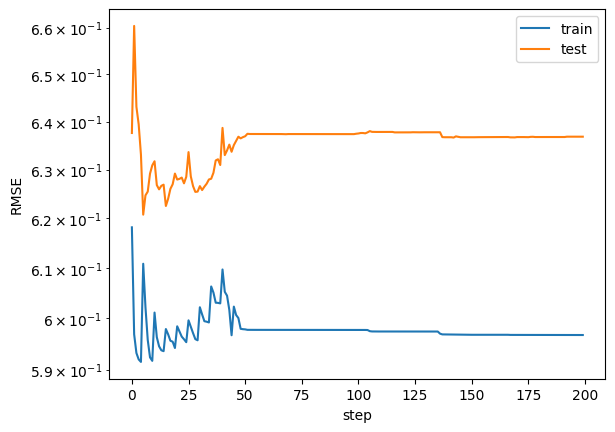

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device, train_num=1000)

steps = 200
k = 3
grids = 5

model = KAN(width=[2,1,1], grid=grids, k=k, seed=0, device=device)

results = model.fit(dataset, opt="LBFGS", steps=steps)
train_losses = results['train_loss']
test_losses = results['test_loss']


plt.plot(train_losses)
plt.plot(test_losses)

plt.legend(['train', 'test',])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

| train_loss: 6.12e-01 | test_loss: 6.58e-01 | reg: [0.7824541926383972, 0.7099206447601318, 0.70608


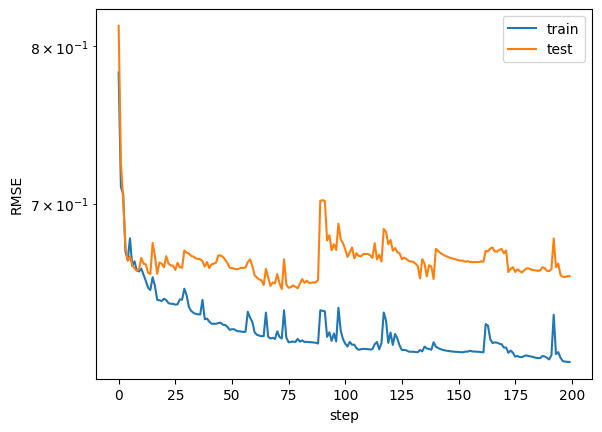

In [23]:
steps2 = 200
k2 = 3
grids2 = 5

my_model = MyKAN(width=[2,1,1], grid=grids2, k=k2, seed=0, device=device)


my_results = my_model.fit(dataset, opt="LBFGS", steps=steps)
my_train_losses = my_results['train_loss']
my_test_losses = my_results['test_loss']


plt.plot(my_train_losses)
plt.plot(my_test_losses)

plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')